In [1]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
import os

#(a) Data cleaning

In [2]:
# Importing 'drive' module
from google.colab import drive
drive.mount('/content/drive')

# Replace the below line with your current working path if neccessary, or remove it
os.chdir('/content/drive/MyDrive/COMP 6936 - Advanced Machine Learning/Assignment 1')

current_directory = os.getcwd()

file_path = current_directory + '/titanic.csv'

# Load the Titanic dataset
titanic = pd.read_csv(file_path)

# Keep only the columns `Survived`, `Pclass`, `Sex`, `Age`, and `Fare`
titanic = titanic[['Survived', 'Pclass', 'Sex', 'Age', 'Fare']]

# Remove rows with NaN or missing values
titanic.dropna(inplace=True)

# Convert `Survived` and `Pclass` to categorical
titanic['Survived'] = titanic['Survived'].astype('category')
titanic['Pclass'] = titanic['Pclass'].astype('category')

# Save the cleaned dataset to a new CSV file
save_path = current_directory + '/titanic_cleaned.csv'
titanic.to_csv(save_path, index=False)

# Split the data into training and test sets, with every fifth row going into the test set
titanic_test = titanic.iloc[4::5]
titanic_train = titanic.drop(titanic_test.index)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Replace with your own file path if neccessary
save_path2 = current_directory + '/titanic_train.csv'
titanic_train.to_csv(save_path2)

#(b) Fit the GAMs

In [4]:
# Define the formula for the model
formula = "Survived ~ Pclass + Sex + Age + Fare"

# Create the GAM model
model = smf.glm(formula=formula, data=titanic_train, family=sm.families.Binomial())

# Fit the model
result = model.fit()

# Get the p-values from the model summary
p_values = result.pvalues

# Initialize an empty list to store the insignificant features
insignificant_features = []

# Loop through the p-values and column names
for i, column in enumerate(p_values.index):
    # If the p-value is greater than 0.05, add the column name to the list of insignificant features
    if p_values[i] > 0.05:
        insignificant_features.append(column)

print("Insignificant features:", insignificant_features)

Insignificant features: ['Fare']


<ipython-input-4-fc2e61e6dce9>:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if p_values[i] > 0.05:


#(c) Effective degree of freedom

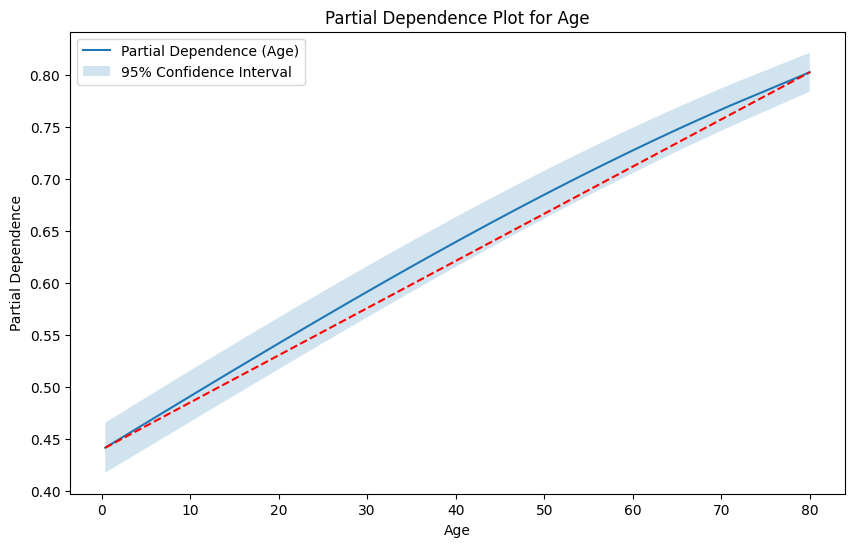

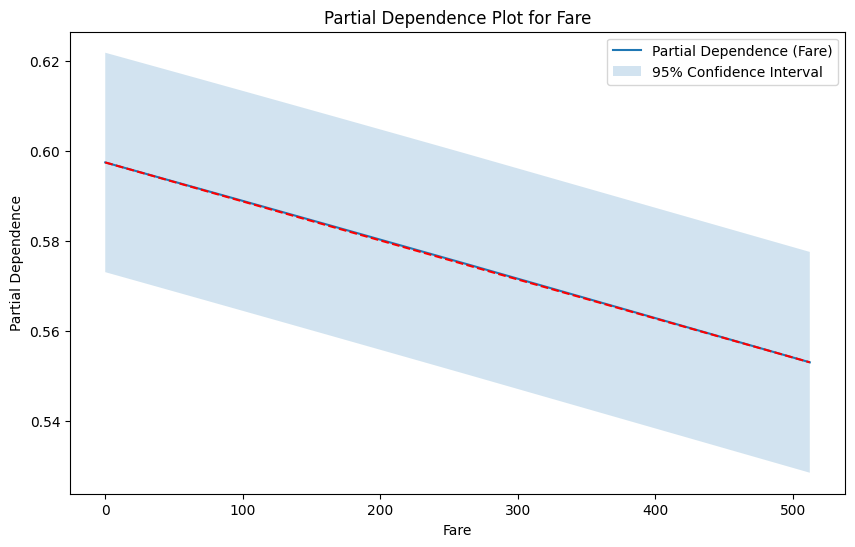

In [5]:
# Function to calculate partial dependence with confidence intervals
def calculate_partial_dependence(model, data, feature):
    # Get the unique values of the feature
    unique_values = sorted(data[feature].unique())

    # Initialize empty lists to store the partial dependence values and confidence intervals
    pd_values = []
    lower_ci = []
    upper_ci = []

    # Loop through the unique values of the feature
    for value in unique_values:
        # Create a copy of the data
        data_copy = data.copy()

        # Set the feature to the current value
        data_copy[feature] = value

        # Predict the probabilities
        predictions = model.predict(data_copy)

        # Calculate the average prediction and the 95% confidence interval
        average_prediction = np.mean(predictions)
        se = np.std(predictions) / np.sqrt(len(predictions))
        lower = average_prediction - 1.96 * se
        upper = average_prediction + 1.96 * se

        # Add the values to the lists
        pd_values.append(average_prediction)
        lower_ci.append(lower)
        upper_ci.append(upper)

    # Return the unique values, partial dependence values, and confidence intervals
    return unique_values, pd_values, lower_ci, upper_ci

# Calculate partial dependence for `Age`
age_values, age_pd_values, age_lower_ci, age_upper_ci = calculate_partial_dependence(result, titanic_train, 'Age')

# Create the partial dependence plot for `Age`
plt.figure(figsize=(10, 6))
plt.plot(age_values, age_pd_values, label='Partial Dependence (Age)')
plt.fill_between(age_values, age_lower_ci, age_upper_ci, alpha=0.2, label='95% Confidence Interval')
plt.plot([age_values[0], age_values[-1]], [age_pd_values[0], age_pd_values[-1]], 'r--')  # Add straight line
plt.title('Partial Dependence Plot for Age')
plt.xlabel('Age')
plt.ylabel('Partial Dependence')
plt.legend()
plt.show()

# Calculate partial dependence for `Fare`
fare_values, fare_pd_values, fare_lower_ci, fare_upper_ci = calculate_partial_dependence(result, titanic_train, 'Fare')

# Create the partial dependence plot for `Fare`
plt.figure(figsize=(10, 6))
plt.plot(fare_values, fare_pd_values, label='Partial Dependence (Fare)')
plt.fill_between(fare_values, fare_lower_ci, fare_upper_ci, alpha=0.2, label='95% Confidence Interval')
plt.plot([fare_values[0], fare_values[-1]], [fare_pd_values[0], fare_pd_values[-1]], 'r--')  # Add straight line
plt.title('Partial Dependence Plot for Fare')
plt.xlabel('Fare')
plt.ylabel('Partial Dependence')
plt.legend()
plt.show()

#(d) Prediction with GAMs

In [6]:
# Predict the `Survived` values for the data in the test set
predictions = result.predict(titanic_test[['Pclass', 'Sex', 'Age', 'Fare']])
predictions = np.where(predictions > 0.5, 1, 0)

# Calculate the accuracy, precision, recall and F1 score
accuracy = accuracy_score(titanic_test['Survived'], predictions)
precision = precision_score(titanic_test['Survived'], predictions)
recall = recall_score(titanic_test['Survived'], predictions)
f1 = f1_score(titanic_test['Survived'], predictions)

# Print the evaluation metrics
print(f"Accuracy: {np.round(accuracy*100, 2)} %")
print(f"Precision: {np.round(precision*100, 2)} %")
print(f"Recall: {np.round(recall*100, 2)} %")
print(f"F1 Score: {f1}")

Accuracy: 17.61 %
Precision: 12.66 %
Recall: 17.24 %
F1 Score: 0.145985401459854
